# Recall oriented evaluation of info-loss Q/A

## Notebook Setup

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [14]:
from dotenv import load_dotenv

load_dotenv()

import ast
import os
import random
from typing import List, Tuple
import html
import json
from collections import Counter


from label_studio_sdk import Client
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from tqdm.auto import tqdm
import seaborn as sns

from info_loss.statistics import load_data, load_data_aggregated, qa_stats
from info_loss import iaa
import utils

## Utility Functions

In [15]:
SIMILARITY_MODEL = SentenceTransformer("all-MiniLM-L6-v2")

In [16]:
# ls = Client(
#     url="https://ut-compling-label-studio-ts-info-loss.hf.space/",
#     api_key=os.environ["LABEL_STUDIO_API_KEY"],
# )

## Load data

Load human annotations and take the union of the Q/A pairs for a recall oriented evaluation. Afterwards, add automatic predictions to these documents. 

Leads to following datastructure:

```json
[
    {
        "id": "<doc id>"
        "source": "...",
        "target": "...",
        "annotations": [
            {
                "annotator": "<name of human annotators>",
                "edits": [...],
                ""
            },
            {
                "annotator": "<name of first model>",
                "edits": [...],
            },
            {
                "annotator": "<name of second model>",
                "edits": [...],
                ""
            }
        ]
    }
]
```

In [17]:
docs = load_data_aggregated(
    annotators=[
        ("karim", "../data/raw/annotations/annotations-karim/"),
        ("keziah", "../data/raw/annotations/annotations-keziah/"),
        ("kathryn", "../data/raw/annotations/annotations-kathryn/"),
    ],
    union=True,
)
docs = list(docs.values())

predictions = load_data_aggregated(
    annotators=[
        ("gpt-4-0613-one-shot", "../output/gpt-4-0613-one-shot/predictions.json"),
        ("gpt-4-0613-nli", "../output/gpt-4-0613-nli/predictions.json"),
        (
            "llama2-70b-chat-one-shot",
            "../output/llama2-70b-chat-one-shot/predictions.json",
        ),
        (
            "mistral-7b-instruct-one-shot",
            "../output/mistral-7b-instruct-one-shot/predictions.json",
        ),
    ],
    union=False,
)

# Add model predictions to the manually annotated documents.
# From here on, we'll only continue with documents where we have a gold annotation.
for doc in docs:
    doc_pred = predictions[doc["id"]]
    doc["annotations"].extend(doc_pred["annotations"])

print("Total annotated document:", len(docs))

Total annotated document: 104


## Calculate pairwise similarity

In [6]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np


def compute_similarity(model, sentences_a, sentences_b):
    embeddings_a = model.encode(sentences_a, convert_to_tensor=True)
    embeddings_b = model.encode(sentences_b, convert_to_tensor=True)
    similarity_scores = util.pytorch_cos_sim(embeddings_a, embeddings_b)
    return similarity_scores

In [7]:
def format_text(text, annotations):
    formatted_text = '<pre style="white-space: pre-wrap; font-size: 12px; font-family: Roboto,-apple-system,BlinkMacSystemFont,Segoe UI,Oxygen,Ubuntu,Cantarell,Open Sans,Helvetica Neue,sans-serif;">'
    current_pos = 0

    for start, end in sorted(annotations):
        # Add the text between the current position and the start of the annotation
        formatted_text += text[current_pos:start]

        # Add the highlighted span
        formatted_text += '<span style="font-weight: bold; background-color: #ff725c;">'
        formatted_text += text[start:end]
        formatted_text += "</span>"

        # Update the current position
        current_pos = end

    # Add the remaining text after the last annotation
    formatted_text += text[current_pos:]
    formatted_text += "</pre>"

    return formatted_text

In [8]:
data = []

for doc in tqdm(docs):
    gold_edits = doc["annotations"][0]["edits"]
    gold_sents = [
        edit["annotation"]["question"] + " " + edit["annotation"]["answer"]
        for edit in gold_edits
    ]

    if len(gold_sents) <= 0:
        continue

    for model in doc["annotations"][1:]:
        model_edits = model["edits"]
        model_sents = [
            edit["annotation"]["question"] + " " + edit["annotation"]["answer"]
            for edit in model_edits
        ]
        if len(model_sents) <= 0:
            continue

        scores = compute_similarity(SIMILARITY_MODEL, gold_sents, model_sents)

        for (i, j), score in np.ndenumerate(scores):
            data.append(
                {
                    "doc_id": doc["id"],
                    "model_name": model["annotator"],
                    "reference_id": gold_edits[i]["id"],
                    "prediction_id": model_edits[j]["id"],
                    "reference_question": gold_edits[i]["annotation"]["question"],
                    "reference_answer": gold_edits[i]["annotation"]["answer"],
                    "reference_highlighted": format_text(
                        doc["source"], gold_edits[i].get("input_idx", [])
                    ),
                    "predicted_question": model_edits[j]["annotation"]["question"],
                    "predicted_answer": model_edits[j]["annotation"]["answer"],
                    "predicted_highlighted": format_text(
                        doc["source"], model_edits[j].get("input_idx", [])
                    ),
                    "score": score,
                }
            )

  0%|          | 0/104 [00:00<?, ?it/s]

## Determine a threshold for evaluation

### Get sample to annotate

Comparing all possible pairs is intractable (33k comparisons). Therefore, we aim to determine a similarity threshold to prune the space of comparisons. We first discretize the similarity score into bins of 0.05 width. Then for each bucket we will sample 20 random pairs and annotate them. For final evaluation we will then take the similarity threshold at which a significant number of recalled/partially recalled sample starts to appear.

First, bin the samples.

In [9]:
# clip similarity to [0, 1] then do the binning. We have a few hundred pairs with similarity < 0
# Convert the pandas categorical to string because it's a bit easier to work below
df = pd.DataFrame(data)
df["bin"] = pd.cut(
    df["score"].clip(0, 1), bins=np.arange(0, 1.05, 0.05), include_lowest=True
).astype(str)
display(df["bin"].value_counts().sort_index())

bin
(-0.001, 0.05]     941
(0.05, 0.1]       1360
(0.1, 0.15]       2228
(0.15, 0.2]       3070
(0.2, 0.25]       3647
(0.25, 0.3]       3705
(0.3, 0.35]       3467
(0.35, 0.4]       3110
(0.4, 0.45]       2709
(0.45, 0.5]       2419
(0.5, 0.55]       1996
(0.55, 0.6]       1537
(0.6, 0.65]       1190
(0.65, 0.7]        889
(0.7, 0.75]        613
(0.75, 0.8]        436
(0.8, 0.85]        261
(0.85, 0.9]        156
(0.9, 0.95]         79
(0.95, 1.0]         12
Name: count, dtype: int64

Then sample 20 pairs per bin and push tasks to label-studio.

In [10]:
def sample_from_group(group):
    return group.sample(min(20, len(group)), random_state=42)


sample = df.groupby("bin", observed=True).apply(sample_from_group)
sample = sample.reset_index(drop=True)

with open("../data/processed/eval-recall-tasks/calibration.json", "w") as fout:
    json.dump(sample.to_dict(orient="records"), fout)

# utils.labelstudio_import(
#     ls,
#     config="../config/label-studio-recall.xml",
#     tasks="../data/processed/eval-recall-tasks/calibration.json",
#     title="Recall Micro | Jan | Calibration"
# )

### Load completed annotations

In [11]:
df_annotations = pd.read_json("../data/raw/eval-recall-annotations/calibration.json")
df_annotations.head(3)

,doc_id,model_name,reference_id,prediction_id,reference_question,reference_answer,predicted_question,predicted_answer,score,bin,id,rating,annotator,annotation_id,created_at,updated_at,lead_time,reference_highlighted,predicted_highlighted,comment
0,5440036,mistral-7b-instruct-one-shot,ffa8ffa5b4405a9dea44f9e0afde92f5,982ea2ff57304593aac96472c4ca1038,How does this study control for bias?,"This study is a double-blind trial, meaning ne...",How long was the assessment period for the sev...,The severity of nausea and vomiting was assess...,0.025102,"(-0.001, 0.05]",519,not_aligned,1,45,2023-11-23 15:23:32.600301+00:00,2023-11-23 15:23:32.600327+00:00,8.604,NaN,NaN,NaN
1,4018698,llama2-70b-chat-one-shot,ee226a1b65dd496d007d67fde18f2a5a,e25bedc907b4bf98b901f7358efb85be,How reliable are these results?,These results were found to be statistically s...,What type and dose of anesthesia were used in ...,The epidural group received 0.5% bupivacaine (...,0.036709,"(-0.001, 0.05]",520,not_aligned,1,46,2023-11-23 15:23:41.486341+00:00,2023-11-23 15:23:41.486376+00:00,7.777,NaN,NaN,NaN
2,4069047,mistral-7b-instruct-one-shot,2e2b64812d492327a089af8883119902,8f8c8fe44c75767948463e200af85540,What was the age range of the patients?,52-85 years.,What is the relationship between melatonin lev...,Melatonin levels are already reduced in precli...,0.045621,"(-0.001, 0.05]",521,not_aligned,1,47,2023-11-23 15:23:47.881767+00:00,2023-11-23 15:23:47.881797+00:00,5.259,NaN,NaN,NaN


Plot the number of fully/partially recalled samples.

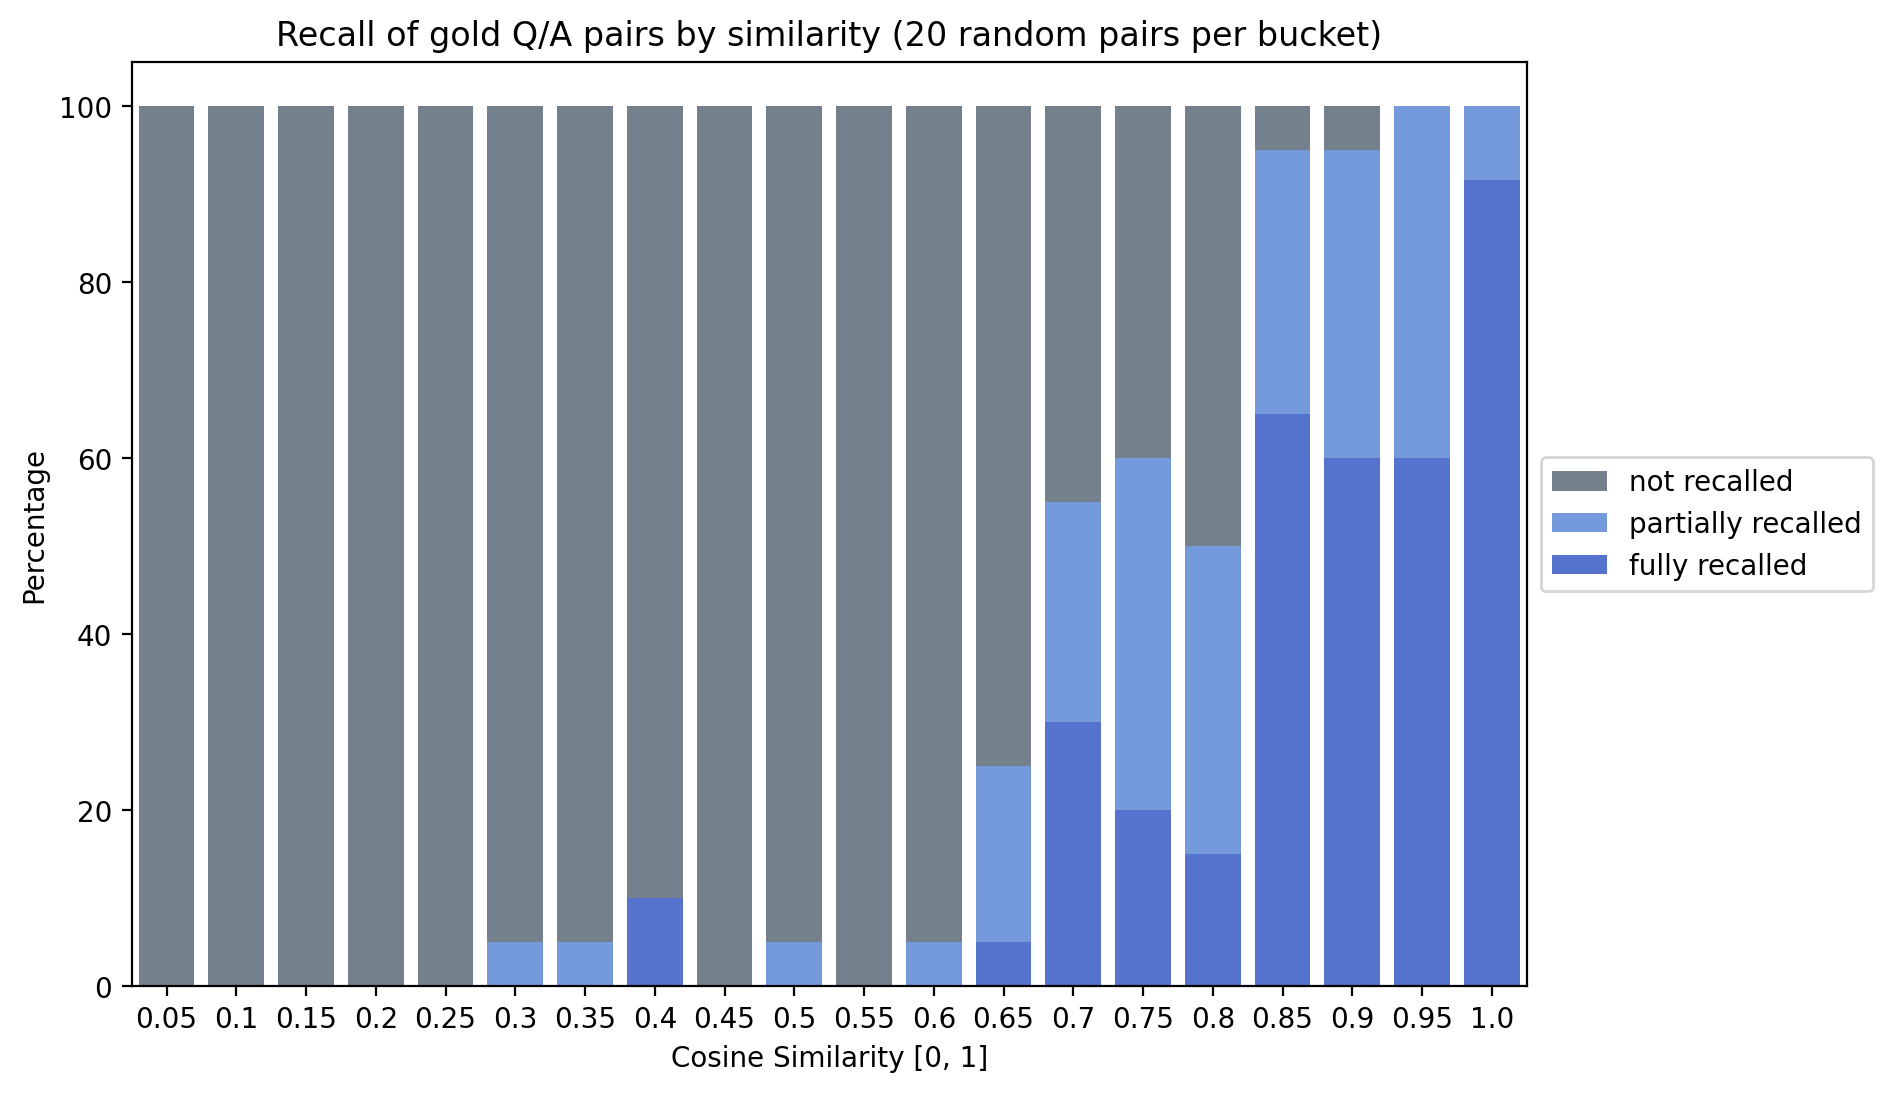

In [12]:
import ast


def extract_upper_bound(interval):
    bounds = ast.literal_eval(
        interval.replace("(", "[")
    )  # Replace '(' with '[' for right-inclusive
    return bounds[1]


right_edges = [extract_upper_bound(bin) for bin in df_annotations["bin"].unique()]
total = (
    pd.Series(data=100, index=df_annotations["bin"].unique())
    .reset_index(name="percentage")
    .rename({"index": "bin"}, axis=1)
)
partial = (
    df_annotations.groupby("bin")["rating"]
    .apply(lambda x: (x == "partial").mean() * 100)
    .reset_index(name="percentage")
)
fully = (
    df_annotations.groupby("bin")["rating"]
    .apply(lambda x: (x == "aligned").mean() * 100)
    .reset_index(name="percentage")
)
partial["percentage"] = fully["percentage"] + partial["percentage"]

plt.figure(figsize=(9, 6))
bar1 = sns.barplot(
    x="bin", y="percentage", data=total, color="slategrey", label="not recalled"
)
bar2 = sns.barplot(
    x="bin",
    y="percentage",
    data=partial,
    color="cornflowerblue",
    label="partially recalled",
)
bar3 = sns.barplot(
    x="bin", y="percentage", data=fully, color="royalblue", label="fully recalled"
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xticks(range(len(right_edges)), right_edges)

plt.ylabel("Percentage")
plt.xlabel("Cosine Similarity [0, 1]")
plt.title("Recall of gold Q/A pairs by similarity (20 random pairs per bucket)")

plt.savefig("figures/percentage_recalled.png", bbox_inches="tight", dpi=300)

Plot the average annotation duration.

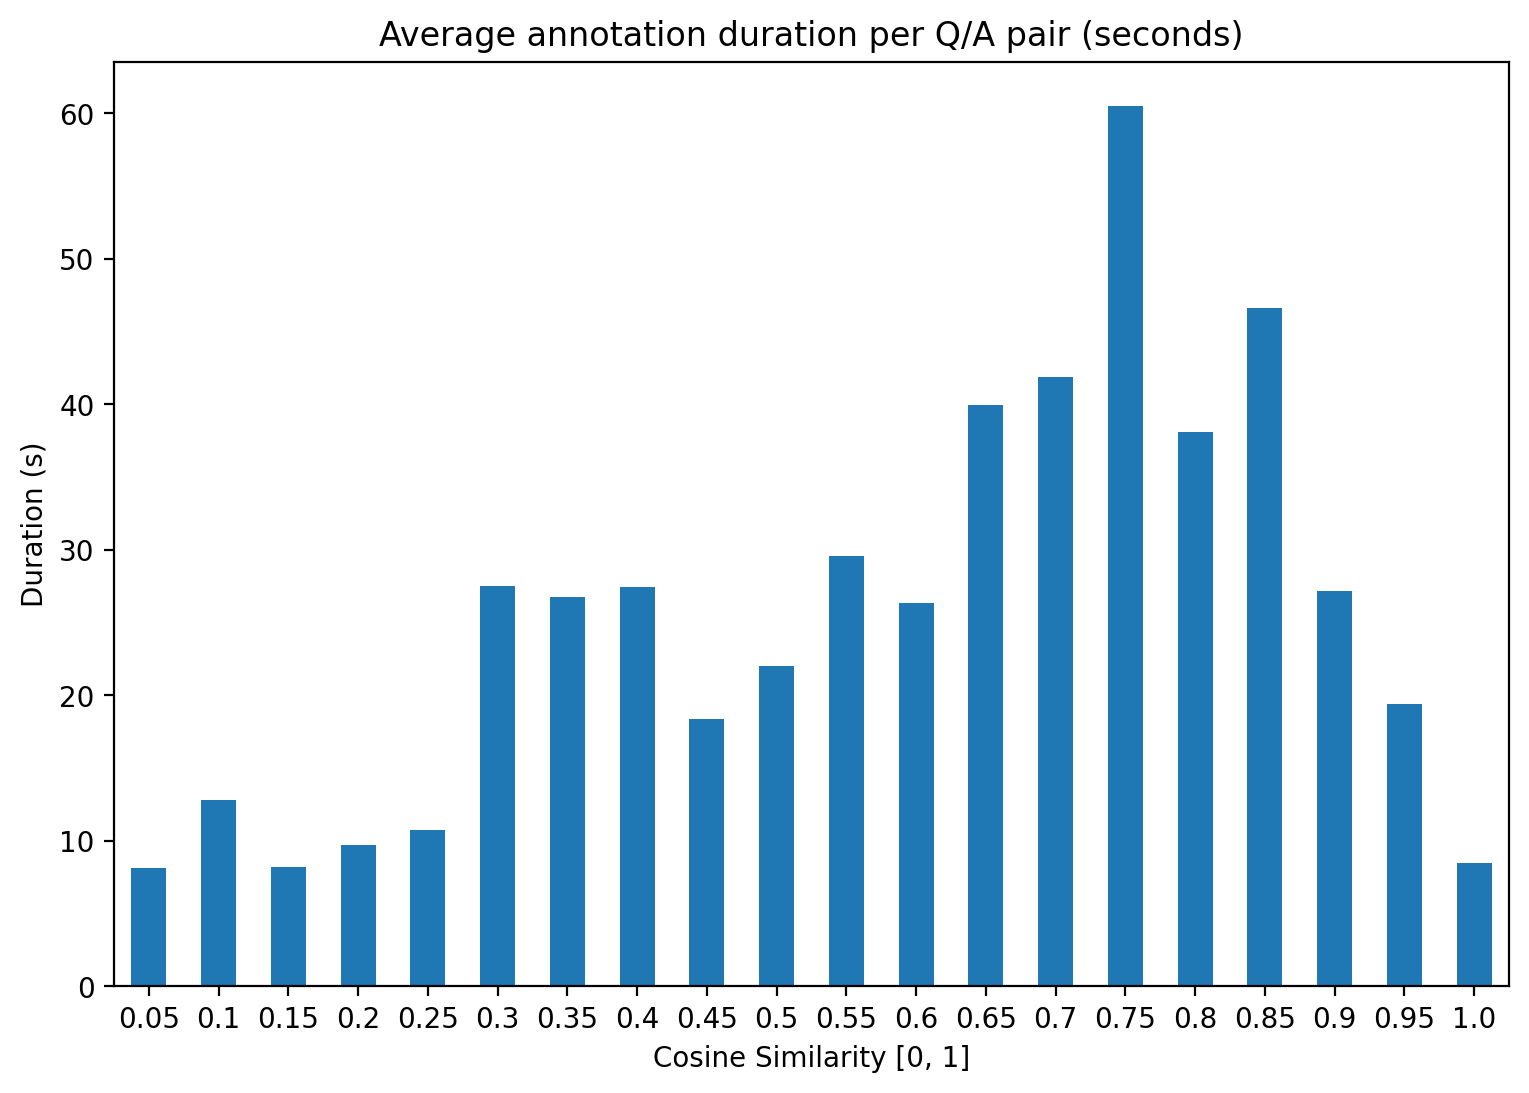

In [13]:
plt.figure(figsize=(9, 6))
df_annotations.groupby("bin")["lead_time"].mean().plot.bar(rot=0)
plt.xticks(range(len(right_edges)), right_edges)
plt.title("Average annotation duration per Q/A pair (seconds)")
plt.ylabel("Duration (s)")
plt.xlabel("Cosine Similarity [0, 1]")

plt.savefig("figures/duration.png", bbox_inches="tight", dpi=300)

Based on this, we will take a threshold of `sim(x, y) > 0.65`.

In [14]:
n_total = len(df)
n_filtered = sum(df["score"] > 0.65)
print(f"Filtering: {n_filtered}/{n_total} ({n_filtered/n_total*100:.1f}%)")

Filtering: 2446/33825 (7.2%)


In [15]:
df_filtered = df[df["score"] > 0.65]

Calculate expected annotation duration when we would annotate all documents.

In [16]:
pairs_by_similarity = df["bin"].value_counts().sort_index().reset_index()
pairs_by_similarity["bin"] = pairs_by_similarity["bin"].astype(str)
duration_by_similarity = (
    df_annotations.groupby("bin")["lead_time"].mean().to_frame().reset_index()
)

# Aggregate stats
stats = pd.merge(pairs_by_similarity, duration_by_similarity, on="bin").set_index("bin")
stats["estimated_duration"] = stats["count"] * stats["lead_time"]

subset = stats.loc["(0.65, 0.7]":]
display(subset)

total_expected_hours = subset["estimated_duration"].sum() / 60 / 60
total_qa = subset["count"].sum()
print(f"Total hours (estimated): {total_expected_hours:.1f}h")
print(f"Total Q/A pairs: {total_qa:,}")

,count,lead_time,estimated_duration
bin,,,
"(0.65, 0.7]",889,41.894000,37243.76600
"(0.7, 0.75]",613,60.476600,37072.15580
"(0.75, 0.8]",436,38.129800,16624.59280
"(0.8, 0.85]",261,46.625850,12169.34685
"(0.85, 0.9]",156,27.180300,4240.12680
"(0.9, 0.95]",79,19.377600,1530.83040
"(0.95, 1.0]",12,8.477083,101.72500


Total hours (estimated): 30.3h
Total Q/A pairs: 2,446


And as a cumulative effort.

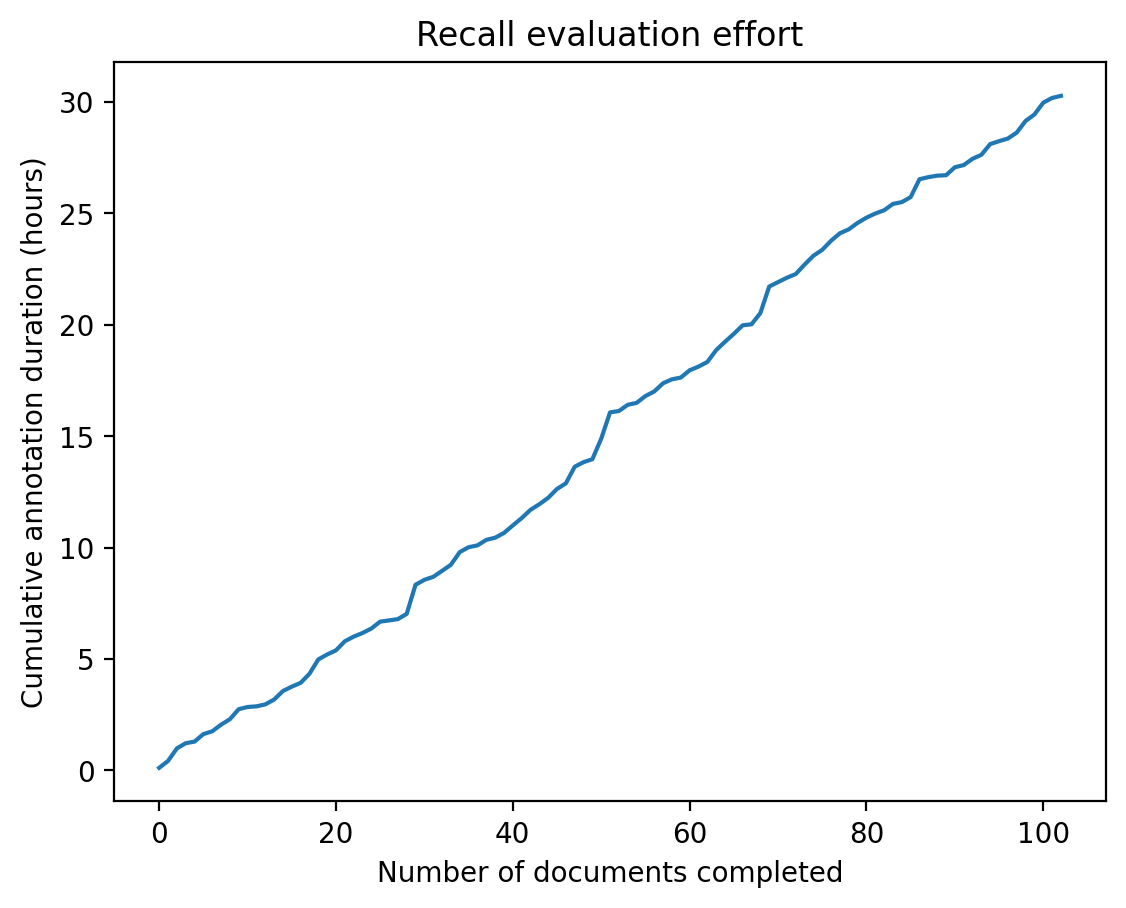

In [17]:
df_duration_by_doc = (
    pd.merge(df_filtered, duration_by_similarity, left_on="bin", right_on="bin")
    .groupby("doc_id")["lead_time"]
    .sum()
)
df_duration_by_doc = df_duration_by_doc.sample(frac=1, random_state=42)
cumulative_duration = df_duration_by_doc.cumsum() / 60 / 60
cumulative_duration = cumulative_duration.reset_index(drop=True)
cumulative_duration.plot.line()
plt.xlabel("Number of documents completed")
plt.ylabel("Cumulative annotation duration (hours)")
plt.title("Recall evaluation effort");

## Assign tasks to annotators

Trial batch of 30 pairs.

In [7]:
# remaining, sample = train_test_split(
#     df_filtered,
#     shuffle=True,
#     random_state=42,
#     stratify=df_filtered["model_name"],
#     test_size=30,
# )
# sample.to_json("../data/processed/eval-recall-tasks/batch1.json", orient="records")

# utils.labelstudio_import(
#     ls,
#     config="../config/label-studio-recall.xml",
#     tasks="../data/processed/eval-recall-tasks/batch1.json",
#     title="Recall | Kathryn | Batch 1",
# )

# utils.labelstudio_import(
#     ls,
#     config="../config/label-studio-recall.xml",
#     tasks="../data/processed/eval-recall-tasks/batch1.json",
#     title="Recall | Keziah | Batch 1",
# )

Get batches. We will annotate documents exhaustively. Therefore, get the list of document IDs, shuffle, and peel off slices for annotation.

In [19]:
random.seed(42)
doc_ids = sorted(df_filtered["doc_id"].unique())
random.shuffle(doc_ids)

# batch = doc_ids[:34]  # batch2
# batch = doc_ids[34:55]  # batch3
batch = doc_ids[55:71]  # batch4

In [20]:
# Shuffle Q/A so that we get all models and degrees of similarity in random order.
df_batch = df_filtered[df_filtered["doc_id"].isin(batch)].sample(
    frac=1, random_state=42
)
# Sort by documents so that annotators always complete one document before moving to the next which should make things easier.
df_batch = df_batch.sort_values("doc_id")
# Annotators were instructed to repeat a Q/A in case it occurs in multiple places in the report.
# Therefore, we may have duplicates in the pairwise comparison. We only need to judge them once.
# The reference_id and prediction_id are hashes based on the question/answer/comment, irrespective of Q/A localization.
df_batch = df_batch[~df_batch.duplicated(["reference_id", "prediction_id"])]
# df_batch.to_json("../data/processed/eval-recall-tasks/batch4.json", orient="records")
len(df_batch)

# utils.labelstudio_import(
#     ls,
#     config="../config/label-studio-recall.xml",
#     tasks="../data/processed/eval-recall-tasks/batch4.json",
#     title="Recall | Kathryn | Batch 4",
# )

# utils.labelstudio_import(
#     ls,
#     config="../config/label-studio-recall.xml",
#     tasks="../data/processed/eval-recall-tasks/batch4.json",
#     title="Recall | Keziah | Batch 4",
# )

415

## Load completed annotations

In [18]:
# Export predictions from label studio
# Batch 1 is trial batch
# utils.labelstudio_export(ls, 29, "../data/raw/eval-recall-annotations/batch1-kathryn.json")
# utils.labelstudio_export(ls, 30, "../data/raw/eval-recall-annotations/batch1-keziah.json")
# utils.labelstudio_export(ls, 33, "../data/raw/eval-recall-annotations/batch2-kathryn.json");
# utils.labelstudio_export(ls, 35, "../data/raw/eval-recall-annotations/batch2-keziah.json");
# utils.labelstudio_export(ls, 43, "../data/raw/eval-recall-annotations/batch3-kathryn.json");
# utils.labelstudio_export(ls, 44, "../data/raw/eval-recall-annotations/batch3-keziah.json");

In [19]:
df_anns_a = pd.concat(
    [
        pd.read_json("../data/raw/eval-recall-annotations/batch2-keziah.json").assign(
            batch="batch2"
        ),
        pd.read_json("../data/raw/eval-recall-annotations/batch3-keziah.json").assign(
            batch="batch3"
        ),
    ],
    ignore_index=True,
)
df_anns_a["annotator"] = "keziah"
df_anns_b = pd.concat(
    [
        pd.read_json("../data/raw/eval-recall-annotations/batch2-kathryn.json").assign(
            batch="batch2"
        ),
        pd.read_json("../data/raw/eval-recall-annotations/batch3-kathryn.json").assign(
            batch="batch3"
        ),
    ],
    ignore_index=True,
)
df_anns_b["annotator"] = "kathryn"

In [20]:
display(df_anns_a.head(3))
print()
display(df_anns_b.head(3))

,doc_id,model_name,reference_id,prediction_id,reference_question,reference_answer,reference_highlighted,predicted_question,predicted_answer,predicted_highlighted,...,bin,id,rating,comment,annotator,annotation_id,created_at,updated_at,lead_time,batch
0,1774569,gpt-4-0613-nli,9cea213fa0014ba6f61b36c46d0aa41e,7ffa9c81b357c84c917ca267c4ddbdaf,How many patients remained abstinent at each t...,10 in the dihydrocodeine remained sober 3 mont...,"<pre style=""white-space: pre-wrap; font-size: ...",How many people stopped using drugs for three ...,Ten people who were given buprenorphine and fo...,"<pre style=""white-space: pre-wrap; font-size: ...",...,"(0.7, 0.75]",2264,partial,no mention of 6 months in the model-generated ...,keziah,1161,2023-12-12 06:39:11.203259+00:00,2023-12-12 20:59:36.697245+00:00,116.447,batch2
1,1774569,gpt-4-0613-nli,800c59cdd97fe420123828b146e3f3d6,be6d78218d0d644787083d18d5db9851,How likely were patients from the buprenorphin...,"Three months after treatment, 10 patients from...","<pre style=""white-space: pre-wrap; font-size: ...",How many people continued to not use drugs for...,"Of the people in the study, seven who were giv...","<pre style=""white-space: pre-wrap; font-size: ...",...,"(0.8, 0.85]",2265,partial,no mention of 3 months in the model-generated ...,keziah,1162,2023-12-12 06:39:35.355152+00:00,2023-12-12 21:00:02.829306+00:00,58.384,batch2
2,1774569,llama2-70b-chat-one-shot,9aa38c5bfd6874dcc2e16694ae27408f,4ff689ec3b063f5aff5cdb489857e1cd,What was the rate of a clean urine sample in t...,"In the buprenorphine group, 21% of patients pr...","<pre style=""white-space: pre-wrap; font-size: ...",What was the statistical significance of the r...,The risk of non-completion of detoxification w...,"<pre style=""white-space: pre-wrap; font-size: ...",...,"(0.65, 0.7]",2266,not_aligned,NaN,keziah,1163,2023-12-12 06:39:47.848264+00:00,2023-12-12 06:39:47.848298+00:00,10.454,batch2


,doc_id,model_name,reference_id,prediction_id,reference_question,reference_answer,reference_highlighted,predicted_question,predicted_answer,predicted_highlighted,...,bin,id,rating,annotator,annotation_id,created_at,updated_at,lead_time,comment,batch
0,1774569,gpt-4-0613-nli,9cea213fa0014ba6f61b36c46d0aa41e,7ffa9c81b357c84c917ca267c4ddbdaf,How many patients remained abstinent at each t...,10 in the dihydrocodeine remained sober 3 mont...,"<pre style=""white-space: pre-wrap; font-size: ...",How many people stopped using drugs for three ...,Ten people who were given buprenorphine and fo...,"<pre style=""white-space: pre-wrap; font-size: ...",...,"(0.7, 0.75]",1406,partial,kathryn,766,2023-12-09 05:09:43.599171+00:00,2023-12-09 05:09:43.599199+00:00,3410.785,NaN,batch2
1,1774569,gpt-4-0613-nli,800c59cdd97fe420123828b146e3f3d6,be6d78218d0d644787083d18d5db9851,How likely were patients from the buprenorphin...,"Three months after treatment, 10 patients from...","<pre style=""white-space: pre-wrap; font-size: ...",How many people continued to not use drugs for...,"Of the people in the study, seven who were giv...","<pre style=""white-space: pre-wrap; font-size: ...",...,"(0.8, 0.85]",1407,partial,kathryn,767,2023-12-09 05:10:23.044140+00:00,2023-12-09 05:10:23.044169+00:00,36.652,NaN,batch2
2,1774569,llama2-70b-chat-one-shot,9aa38c5bfd6874dcc2e16694ae27408f,4ff689ec3b063f5aff5cdb489857e1cd,What was the rate of a clean urine sample in t...,"In the buprenorphine group, 21% of patients pr...","<pre style=""white-space: pre-wrap; font-size: ...",What was the statistical significance of the r...,The risk of non-completion of detoxification w...,"<pre style=""white-space: pre-wrap; font-size: ...",...,"(0.65, 0.7]",1408,not_aligned,kathryn,768,2023-12-09 05:11:27.630255+00:00,2023-12-09 05:11:27.630302+00:00,59.082,NaN,batch2


### Evaluation Stats

In [21]:
ids_completed = df_anns_a["doc_id"].unique()

assert len(df_anns_a) == len(df_anns_b)
assert (df_anns_a["reference_id"] == df_anns_b["reference_id"]).all()
assert (df_anns_a["prediction_id"] == df_anns_b["prediction_id"]).all()

print("Completed documents:", len(ids_completed))
print("Total ratings:", len(df_anns_a))

Completed documents: 55
Total ratings: 1301


In [22]:
n = Counter()
for doc in docs:
    if doc["id"] not in ids_completed:
        continue

    n["human"] += len(doc["annotations"][0]["edits"])
    for model_edits in doc["annotations"][1:]:
        model_name = model_edits["annotator"]
        n[model_name] += len(model_edits["edits"])
n

Counter({'gpt-4-0613-nli': 874,
         'human': 554,
         'llama2-70b-chat-one-shot': 374,
         'mistral-7b-instruct-one-shot': 262,
         'gpt-4-0613-one-shot': 247})

## Inter-annotator Agreement

In [23]:
raters = [
    df_anns_a["rating"],
    df_anns_b["rating"],
]

print(f"Krippendorffs Alpha: {iaa.krippendorffs_alpha(raters):.2f}")
print(f'Fleiss Kappa: {iaa.kappa(raters, method="fleiss"):.2f}')
print(f'Randolphs Kappa: {iaa.kappa(raters, method="randolph"):.2f}')

Krippendorffs Alpha: 0.69
Fleiss Kappa: 0.69
Randolphs Kappa: 0.70


## Total Annotation Duration

In [24]:
df_all_annotations = pd.concat([df_anns_a, df_anns_b], ignore_index=True)

q95 = df_all_annotations["lead_time"].quantile(0.95)
lead_time_clipped = df_all_annotations["lead_time"].clip(0, q95)

total = lead_time_clipped.sum()
median = lead_time_clipped.median()
print(f"Samples: {len(df_all_annotations)}")
print(f"Total duration: {total / 60 / 60:.0f} hours")
print(f"Median per sample: {median:.1f} seconds")

Samples: 2602
Total duration: 20 hours
Median per sample: 11.9 seconds


## Evaluate recall

In [25]:
def evaluate_recall(reference_ids, predictions):
    """
    predictions: tuple(reference_id, prediction_id, rating)
    """
    tallies = {i: {"aligned": 0, "partial": 0, "not_aligned": 0} for i in reference_ids}

    for ref_id, pred_id, rating in predictions:
        tallies[ref_id][rating] += 1

    ratings_agg = {}
    for i, tally in tallies.items():
        if tally["aligned"] > 0:
            ratings_agg[i] = "aligned"
        elif tally["partial"] > 0:
            ratings_agg[i] = "partial"
        else:
            ratings_agg[i] = "not_aligned"

    counts = Counter(ratings_agg.values())
    assert sum(counts.values()) == len(reference_ids)
    return counts

Get a "flat" dataframe where one row = one q/a

In [26]:
reference_data = []
for doc in docs:
    edits = doc["annotations"][0]["edits"]
    for edit in edits:
        reference_data.append(
            {
                "doc_id": doc["id"],
                "reference_id": edit["id"],
                "category": edit["category"],
                "question": edit["annotation"]["question"],
                "answer": edit["annotation"]["answer"],
                "input_idx": edit["input_idx"],
                "output_idx": edit.get("output_idx"),
            }
        )

df_reference = pd.DataFrame(reference_data)
df_reference = df_reference[df_reference["doc_id"].isin(ids_completed)]
df_reference = df_reference[~df_reference["reference_id"].duplicated()]
print(
    f"total references: {len(df_reference)} across {df_reference.doc_id.nunique()} docs"
)
df_reference.head(5)

total references: 551 across 55 docs


,doc_id,reference_id,category,question,answer,input_idx,output_idx
0,1774569,202e97f36276b32e3b78695f0e302b90,omission,Where are the tested drugs hoping to be used t...,"In primary care, which is day to day health-ca...","[[296, 309]]",None
1,1774569,b6e55fb2f31ed48813064d4d5e280ec3,concept,Which illegal drugs are being addressed by the...,"Opiates, which are drugs such as morphine or h...","[[78, 99]]","[[80, 100], [299, 324]]"
2,1774569,6074664f5b973e5b6b3ed1e752379bc2,concept,What other parameters was the study done under?,"The study was also open label, meaning both th...","[[320, 330]]","[[428, 456]]"
3,1774569,f3186201beeb183a956e2425c6ee724c,concept,How were these drugs administered?,"Buprenorphine was taken sublingually, meaning ...","[[479, 533]]","[[472, 504]]"
4,1774569,d0404d282a248df38bc9cdc63753ce70,concept,How much more likely were the buprenorphine gr...,"They had an 88% finish rate, versus a 68% rate...","[[1116, 1128]]","[[1022, 1069]]"


In [27]:
reference_ids = df_reference["reference_id"]
df_anns = pd.concat([df_anns_a, df_anns_b])

models = set(df_anns["model_name"])
annotators = set(df_anns["annotator"])

print("models:", models)
print("annotators:", annotators)

models: {'gpt-4-0613-nli', 'gpt-4-0613-one-shot', 'llama2-70b-chat-one-shot', 'mistral-7b-instruct-one-shot'}
annotators: {'kathryn', 'keziah'}


In [28]:
scores = []
for model in models:
    for annotator in annotators:
        mask = (df_anns["model_name"] == model) & (df_anns["annotator"] == annotator)
        anns_filtered = df_anns[mask][
            ["reference_id", "prediction_id", "rating"]
        ].itertuples(index=False)
        counts = evaluate_recall(reference_ids, anns_filtered)
        counts = dict(counts)
        counts["model"] = model
        counts["annotator"] = annotator
        scores.append(counts)

df_scores_raw = pd.DataFrame(scores)
display(df_scores_raw)

sum_by_model = df_scores_raw.drop("annotator", axis=1).groupby("model").sum()
display(sum_by_model)

total_per_row = sum_by_model.sum(axis=1)
assert (
    total_per_row == (len(reference_ids) * 2)
).all()  # times 2 because we have ratings by two annotators each annotator has 0.5 vote

df_recall = sum_by_model.div(total_per_row, axis=0)
display(df_recall)

,not_aligned,aligned,partial,model,annotator
0,309,125,117,gpt-4-0613-nli,kathryn
1,321,127,103,gpt-4-0613-nli,keziah
2,373,156,22,gpt-4-0613-one-shot,kathryn
3,381,154,16,gpt-4-0613-one-shot,keziah
4,438,89,24,llama2-70b-chat-one-shot,kathryn
5,436,90,25,llama2-70b-chat-one-shot,keziah
6,450,79,22,mistral-7b-instruct-one-shot,kathryn
7,451,77,23,mistral-7b-instruct-one-shot,keziah


,not_aligned,aligned,partial
model,,,
gpt-4-0613-nli,630,252,220
gpt-4-0613-one-shot,754,310,38
llama2-70b-chat-one-shot,874,179,49
mistral-7b-instruct-one-shot,901,156,45


,not_aligned,aligned,partial
model,,,
gpt-4-0613-nli,0.571688,0.228675,0.199637
gpt-4-0613-one-shot,0.684211,0.281307,0.034483
llama2-70b-chat-one-shot,0.793103,0.162432,0.044465
mistral-7b-instruct-one-shot,0.817604,0.141561,0.040835


In [29]:
rename_cols = {
    "aligned": "Full ($\\uparrow$)",
    "partial": "Partial",
    "not_aligned": "No ($\\downarrow$)",
}

rename_models = {
    "mistral-7b-instruct-one-shot": "Mistral-7B",
    "llama2-70b-chat-one-shot": "Llama2-70B",
    "gpt-4-0613-one-shot": "GPT-4",
    "gpt-4-0613-nli": "NLI (GPT-4)",
}

tab = df_recall.copy()
tab = tab[rename_cols.keys()]
tab = tab.loc[rename_models.keys()]
tab = tab.rename(rename_cols, axis=1)
tab = tab.rename(rename_models, axis=0)
tab.index.name = None
tab.columns.name = None
tab = tab * 100
tab = (
    tab.style.format(precision=1)
    .highlight_max(axis=0, props="font-weight:bold;", subset=["Full ($\\uparrow$)"])
    .highlight_min(axis=0, props="font-weight:bold;", subset=["No ($\\downarrow$)"])
)

tex = tab.to_latex(
    convert_css=True,
    position="t",
    # column_format='l' + 'c'*len(df.columns),
    hrules=True,
    position_float="centering",
)
tex = tex.replace(r"\begin{table}[t]", "\\begin{table}[t]\n\\small")
# tex = tex.replace(r'\end{table}', r'\end{table*}')
for c in tab.columns:
    tex = tex.replace(c, "\\textbf{" + c + "}")
print(tex)

\begin{table}[t]
\small
\centering
\begin{tabular}{lrrr}
\toprule
 & \textbf{Full ($\uparrow$)} & \textbf{Partial} & \textbf{No ($\downarrow$)} \\
\midrule
Mistral-7B & 14.2 & 4.1 & 81.8 \\
Llama2-70B & 16.2 & 4.4 & 79.3 \\
GPT-4 & \bfseries 28.1 & 3.4 & 68.4 \\
NLI (GPT-4) & 22.9 & 20.0 & \bfseries 57.2 \\
\bottomrule
\end{tabular}
\end{table}



## Export data for automatic evaluation

In [61]:
!mkdir -p ../data/infolossqa-v1.0/evals-recall

In [62]:
df_reference.to_json('../data/infolossqa-v1.0/evals-recall/samples.json', orient='records')

annotation_cols = [
    'doc_id',
    'model_name',
    'reference_id',
    'prediction_id',
    'reference_question',
    'reference_answer',
    'predicted_question',
    'predicted_answer',
    'score',
    'bin',
    'rating',
    'comment',
    'annotator',
]

df_anns_a[annotation_cols].to_json('../data/infolossqa-v1.0/evals-recall/rater-a.json', orient='records')
df_anns_b[annotation_cols].to_json('../data/infolossqa-v1.0/evals-recall/rater-b.json', orient='records')